In [2]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets
import scipy
from numba import jit, njit, prange
import time
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Cheat sheet
$$I[u] = \frac{1}{2p} \sum_{i,j=1}^n w_{i j} | \nabla u(x_i,x_j) |^p - \sum_{j=1}^m(y_j - \bar{y}) \cdot u(x_j)$$
where $$ \nabla u(x_i, x_j) = u(x_j) - u(x_i) $$
$$ \frac{\partial I}{\partial u_{rs}} = \sum_{i=1}^n |\nabla u (x_i, x_j)|^{p-2}(u_{rs} - u_{is}) - B_{rs} $$
where $B \in \mathbb{R}^{n \times k}, B_{rs} = y_{rs} - \bar{y}$ when $r \leq m$ and $B_{rs} = 0$ when $r>m$.

$$ \frac{\partial^2 I}{\partial u_{rs} \partial u_{r's'}} = (p-2) \sum_{i=1}^n w_{ir} | \nabla u(x_i,x_r) |^{p-4} (u_{rs'} - u_{is'})(\delta_{r r'} - \delta_{i r'}) + \delta_{s s'} \sum_{i=1}^n w_{ir} | \nabla u(x_i,x_r) |^{p-2} (\delta_{r r'} - \delta_{i r'})$$

## Core functions

In [164]:
# Calculates vector of degrees for the weight matrix W
# W: (n,k) numpy array
@jit(forceobj=True)
def degrees(W):
    return W.sum(axis = 1)

# Example
# Calculates degrees of equilateral triangle
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# print(degrees(W))

"""
Computes the gradient of u
u: (n,k) matrix

Returns:
gradu: (n, n, k)

where gradu[i, j, l] = u[j,l]-u[i,l]
"""
@jit(forceobj=True)
def grad(u):
    gradu = -u[:, np.newaxis] + u

    return gradu

# # Example:
# u = np.arange(6).reshape(3,2)
# print("u is\n", u)
# print("\nAnd gradu is")
# for i in range(u.shape[0]):
#     for j in range(u.shape[1]):
#         print(grad(u)[i,j], end = "\t\t")
#     print()

"""
u_flattened: n*k matrix
W: weight matrix
y: (m,k) matrix
idx = vector of labelled indices
p = p constant for laplace operator
"""
@jit(forceobj=True)
def penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = (1/(2*p)) * (W * (np.apply_along_axis(np.linalg.norm, 2, gradu) ** p)).sum()
    second_summand = np.sum( (y - y_bar) * u[idx] )

    return first_summand - second_summand

# ## Example (see pdf)
# u = np.array([[1,0], [0,1], [1/2, 1/2]])
# print(grad(u))
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# p = 2

# #print(np.apply_along_axis(np.linalg.norm, 2, grad(u)))
# print("2-energy is", penergy(u, W, idx, y, 2))
# print("3-energy is", penergy(u, W, idx, y, 3))

"""
Returns the jacobian of the p-energy
Note that it is now used anywhere.
"""
@jit(forceobj=True)
def jacobian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]

    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    y_bar = y.sum(axis = 0)/m

    jacob = np.zeros((n, k))
    jacob[idx] = -y + y_bar # First add the derivative of the second summand
    
    
    for r in range(n):
        for s in range(k):
            jacob[r,s] += (W[:, r] * ( np.apply_along_axis(np.linalg.norm, 2, gradu)[:, r]**(p-2) ) * (u[r,s] - u[:, s])).sum()

    return jacob.flatten()

## Example
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# n = 3
# k = 2
# m = 2
# p = 3
# u = np.random.random(size = (n,k))

# print(jacobian(u.flatten(), W, idx, y, p))

# r = s = 0
# gradu = grad(u)
# y_bar = y.sum(axis = 0)/m

# scipy.optimize.check_grad(penergy, jacobian, u.flatten(), W, idx, y, p)

"""
Returns the hessian of the p-energy
Argunents
"""
@jit(forceobj = True, parallel=True)
def hessian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]

    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    normed_gradu = np.apply_along_axis(np.linalg.norm, 2, gradu)
    hess = np.zeros((n,k,n,k))
    
    D = np.subtract.outer(u, u)
    
    for r in prange(n):
        for rr in prange(n):
            for s in prange(k):
                for ss in prange(k):
                    if r == rr:
                        hess += (p-2) * ((W * normed_gradu**(p-4))[:, r] * (u[r, ss] - u[:, ss]) ).sum()
                    hess -= (p-2) * (W * normed_gradu**(p-4))[rr, r] * D[r, ss, rr, ss]
                    if r == rr and s == ss:
                        hess += ((W * normed_gradu**(p-2))[:, r]).sum()
                    if s == ss:
                        hess += (W * (normed_gradu) ** (p-2))[rr, r]
    return hess.reshape(n, k, -1).reshape(n*k, -1)

@jit(forceobj=True, parallel = True)
def vectorized_hessian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]

    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    normed_gradu = np.apply_along_axis(np.linalg.norm, 2, gradu)
    hess = np.zeros((n,k,n,k))
    
    u11 = np.zeros( (n, n, k, n, k) ) + u # u11[i, r', s', r, s] = u[r,s]
    u1 = np.transpose(u11, (0,3,4,1,2))

    
    u21 = np.zeros( (n, k, n, n, k) ) + u # u21[r, s, r', i, s'] = u[i,s']
    u2 =  np.transpose(u21, (3, 0, 1, 2, 4)) # u2[i, r, s, r', s'] = u[i,s]
    
    B = u1 - u2
    
    d11 = np.zeros( (n, k, k, n, n) ) + np.eye(n) # d11[i, s, s', r, r'] = I[r, r']
    d1 = np.transpose(d11, (0, 3, 1, 4, 2)) # d1[i, r, s, r', s'] = I[r, r']

    d21 = np.zeros( (n, k, k, n, n) ) + np.eye(n) # d21[r, s, s', i, r'] = I[i, r']
    d2 = np.transpose(d21, (3, 0, 1, 4, 2)) # d2[i, r, s, r', s'] = I[i, r']

    C = d1 - d2
    
    a1 = np.zeros( (k, n, k, n, n) ) + W * (normed_gradu)**(p-4) # a1[s, r', s', i, r] = ...[i,r]
    A = np.transpose(a1, (3, 4, 0, 1, 2)) # a[i, r, s, r', s'] = ...[i,r]
    
    f1 = np.zeros( (k, n, k, n, n) ) + W * (normed_gradu)**(p-2) # f1[s, r', s', i, r] = ...[i,r]
    F = np.transpose(f1, (3, 4, 0, 1, 2)) # F[i, r, s, r', s'] = ...[i,r]
    
    e1 = np.zeros( (n, n, k, k) ) + np.eye(k) # e1[r, r', s, s'] = I[s, s']
    E = np.swapaxes(e1, 1, 2) # e[r, s, r', s'] = I[s, s']
    
    first_summand = (p-2) * (A * B * C).sum(axis=0)
    second_summand = E * (F * C).sum(axis = 0)
    hess = first_summand + second_summand
    
    return hess.reshape(n, k, -1).reshape(n*k, -1)

"""
Returns the ith vector of the usual basis of R^k
Index starts at 0
"""
@jit(forceobj=True)
def euclidean_basis(i, k):
    eye = np.eye(k)
    return eye[i]

# Example
# print(euclidean_basis(0, 4))
# print(euclidean_basis(2, 4))

# Returns the labels that u predicts
@jit(forceobj=True)
def predict(u):
    return np.argmax(u, axis = 1)

# Solves the p-poisson equation on a graph with weight matrix W
# and labels y on the elements with indices idx
# using gradient descent
@jit(forceobj=True)
def gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = np.zeros(n * k), args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    u = res.x.reshape(n,k)
    
    return u

# ############## Toy example using gradient descent
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# p = 2

# u = gradient_ppoisson(W, idx, y, p)
# print("Minimizer:\n", u)
# print("Energy of minimizer:", penergy(u, W, idx, y, p))
# print("Negative Laplacian values:", 2*u[0]-u[1]-u[2], 2*u[1]-u[0]-u[2], 2*u[2]-u[0]-u[1], sep="\n")
# print("Labels:", predict(u))

# ############## Toy example using GraphLearn
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# d = degrees(W)
# idx = [0, 1]
# n = 3
# k = 2
# p = 2

# model = gl.ssl.poisson(W)
# u = model.fit(idx, np.array([0, 1]))
# # print(2*u[0]-u[1]-u[2])
# # print(2*u[1]-u[0]-u[2])
# # print(2*u[2]-u[0]-u[1])
# # print(u[0] + u[1] + u[2])
# print("GraphLearn solution: \n", u)

# # Toy example using custom implementation
# my_u = gradient_ppoisson(W, idx, y, p)
# print("Custom solution: \n", my_u)

"""
W : (n,n) weight matrix
idx: (m,) vector containing indices of labeled nodes
y: (m, k) array of labels, y[i] = label for node idx[i]

Returns:
u: (n,k) solution to ppoison equation

Description:
First runs GraphLearn implementation and then uses the result
as a starting point for the minimization of the p-energy.
Note:
For the minimization, no apriori Hessian is given.
"""

@jit(forceobj=True)
def started_gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    labels = predict(y)
    model = gl.ssl.poisson(W, solver='gradient_descent')
    start = model.fit(idx, labels).flatten()
        
    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = start, args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    
    u = res.x.reshape(n,k)
    
    return u

"""
W : (n,n) weight matrix
idx: (m,) vector containing indices of labeled nodes
y: (m, k) array of labels, y[i] = label for node idx[i]

Returns:
u: (n,k) solution to ppoison equation

Description:
First runs GraphLearn implementation and then uses the result
as a starting point for the minimization of the p-energy,
with apriori info on computing the Hessian.
"""
@jit(forceobj=True)
def hess_gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    labels = predict(y)
    model = gl.ssl.poisson(W, solver='gradient_descent')
    start = model.fit(idx, labels).flatten()
        
    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = start, args = (W, idx, y, p), hess = hessian, method = 'trust-constr', constraints = linear_constraint)
    
    u = res.x.reshape(n,k)
    
    return u

@jit(forceobj=True)
def vectorized_hess_gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    labels = predict(y)
    model = gl.ssl.poisson(W, solver='gradient_descent')
    start = model.fit(idx, labels).flatten()
        
    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = start, args = (W, idx, y, p), hess = vectorized_hessian, method = 'trust-constr', constraints = linear_constraint)
    
    u = res.x.reshape(n,k)
    
    return u

## Compare custom gradient descent with and without apriori hessian for p = 16

########### Hessian Gradient Descent for p = 16
Energy = -11.35
Accuracy = 94.00%
Runtime = 67.66 min


/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


########### Regular Gradient Descent for p = 16
Energy = -11.36
Discrepancies = 1Accuracy = 92.00%
Runtime = 43.89 min


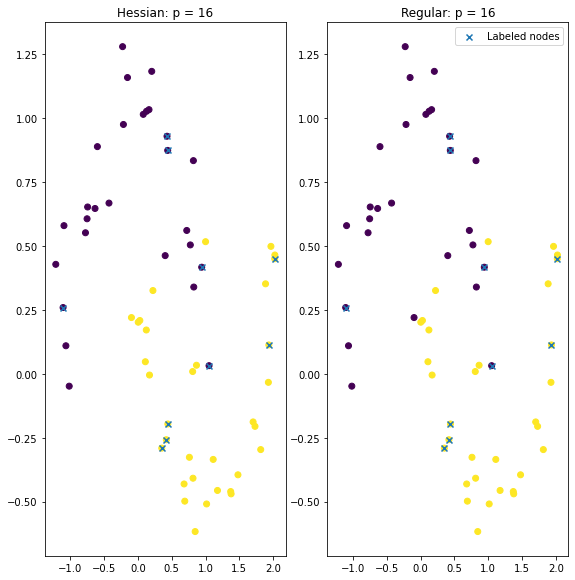

In [92]:
n = 60
k = 2
p = 16

fig, ax = plt.subplots(ncols = 2, figsize = (8, 8))
fig.tight_layout()

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)
    
# Hessian Gradient Descent
start_time = time.time()
hess_u = hess_gradient_ppoisson(W, train_ind, y, p)
hess_pred_labels = predict(hess_u)

accuracy = gl.ssl.ssl_accuracy(hess_pred_labels, labels, len(train_ind))
energy = np.around(penergy(hess_u.flatten(), W, train_ind, y, p), 2)
end_time = time.time()
minutes = (end_time - start_time)/60

info_str = f"########### Hessian Gradient Descent for p = {p}\n"\
                f"Energy = {energy:.2f}\n"\
                f"Accuracy = {accuracy:.2f}%\n"\
                f"Runtime = {minutes:.2f} min"

print(info_str)

ax[0].scatter(X[:,0],X[:,1], c=hess_pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
ax[0].set_title(f"Hessian: p = {p}")


# Regular Gradient Descent
start_time = time.time()
my_u = started_gradient_ppoisson(W, train_ind, y, p)
my_pred_labels = predict(my_u)

discrepancies = np.count_nonzero(my_pred_labels - hess_pred_labels)
accuracy = gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind))
energy = np.around(penergy(my_u.flatten(), W, train_ind, y, p), 2)
end_time = time.time()
minutes = (end_time - start_time)/60

info_str = f"########### Regular Gradient Descent for p = {p}\n"\
                f"Energy = {energy:.2f}\n"\
                f"Discrepancies = {discrepancies}"\
                f"Accuracy = {accuracy:.2f}%\n"\
                f"Runtime = {minutes:.2f} min"

print(info_str)

ax[1].scatter(X[:,0],X[:,1], c=my_pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
ax[1].set_title(f"Regular: p = {p}")

plt.legend()
plt.show()

## Comparing GraphLearn and Gradient Descent solution for p = 2

Energy of GraphLearning Solution: -11.94955101093794
Energy of custom solution: 1473.2714786879228
Accuracy of custom solution: 100.0
Accuracy of GraphLearn solution: 100.0
Number of different predictions 0


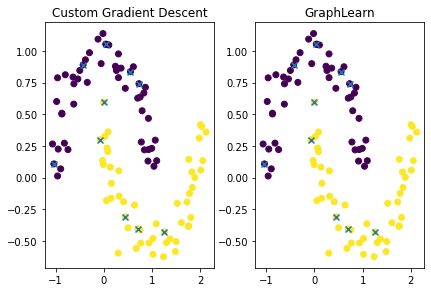

In [5]:
n = 100
k = 2
p = 3
fig, ax = plt.subplots(ncols = 2)
fig.tight_layout()

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)
    
# Custom Gradient Descent
my_u = started_gradient_ppoisson(W, train_ind, y, p = 2)
my_pred_labels = predict(my_u)

ax[0].scatter(X[:,0],X[:,1], c=my_pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[0].set_title("Custom Gradient Descent")

# Using graph learning toolkit
train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)
ax[1].scatter(X[:,0],X[:,1], c=pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[1].set_title("GraphLearn")

print("Energy of GraphLearning Solution:", penergy(u.flatten(), W, train_ind, y, p))
print("Energy of custom solution:", penergy(my_u.flatten(), W, train_ind, y, p))
print("Accuracy of custom solution:", gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind)))
print("Accuracy of GraphLearn solution:", gl.ssl.ssl_accuracy(pred_labels, labels, len(train_ind)))
print("Number of different predictions", np.count_nonzero(my_pred_labels - pred_labels))

plt.show()

## Comparing gradient descent solution for varying values of p

########### GraphLearning
Energy = -11.04
Accuracy = 98.00%
Runtime = 0.01 min
########### Custom Gradient Descent for p = 2
Energy = -17.02
Discrepancies = 1
Accuracy = 96.00%
Runtime = 5.47 min
########### Custom Gradient Descent for p = 4
Energy = -13.39
Discrepancies = 4
Accuracy = 90.00%
Runtime = 10.35 min


/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


########### Custom Gradient Descent for p = 8
Energy = -12.08
Discrepancies = 6
Accuracy = 86.00%
Runtime = 55.88 min
########### Custom Gradient Descent for p = 16
Energy = -10.99
Discrepancies = 8
Accuracy = 82.00%
Runtime = 44.73 min
########### Custom Gradient Descent for p = 32
Energy = 2308.72
Discrepancies = 2
Accuracy = 94.00%
Runtime = 41.15 min
########### Custom Gradient Descent for p = 64
Energy = 1059187.79
Discrepancies = 2
Accuracy = 94.00%
Runtime = 41.26 min
########### Custom Gradient Descent for p = 128
Energy = 2995905039089.01
Discrepancies = 2
Accuracy = 94.00%
Runtime = 42.99 min
########### Custom Gradient Descent for p = 256
Energy = 656001555168201338190007180418158584828694950275613690475982008692198969495937653167481813336868396977943500820486827670549078480154263552.00
Discrepancies = 0
Accuracy = 98.00%
Runtime = 0.08 min


/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:137: RuntimeWarning: overflow encountered in power
  fx = fun(np.copy(x), *args)
/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:137: RuntimeWarning: invalid value encountered in multiply
  fx = fun(np.copy(x), *args)


ValueError: array must not contain infs or NaNs

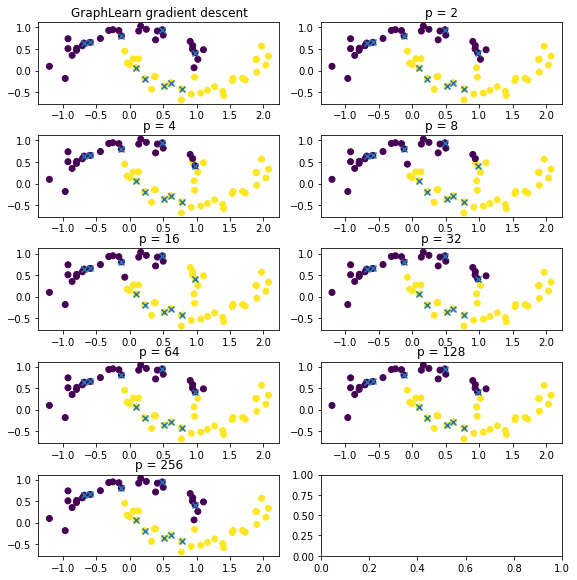

In [7]:
n = 60
k = 2
p_vals = [[0, 2], [4, 8], [16, 32], [64, 128], [256, 512]]

solutions = np.zeros( (len(p_vals) * 2, n, k) ) # Stores the values of the solution for different p

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)

fig, ax = plt.subplots(nrows = len(p_vals), ncols = len(p_vals[0]), figsize = (8, 8))
fig.tight_layout()

# Run and plot for varying p
for i in range(len(p_vals)):
    for j in range(len(p_vals[i])):
        start_time = time.time()

        p = p_vals[i][j]

        if p == 0: # Apply GraphLearning
            model = gl.ssl.poisson(W, solver='gradient_descent')
            u = model.fit(train_ind, train_labels)
            pred_labels = predict(u)
            
            misclassifications = np.count_nonzero(pred_labels - labels)
            accuracy = gl.ssl.ssl_accuracy(pred_labels, labels, len(train_ind))
            energy = np.around(penergy(u.flatten(), W, train_ind, y, 2), 2)
            end_time = time.time()
            minutes = (end_time - start_time)/60

            info_str = f"########### GraphLearning\n"\
                            f"Misclassifications: {misclassifications}"\
                            f"Energy = {energy:.2f}\n"\
                            f"Accuracy = {accuracy:.2f}%\n"\
                            f"Runtime = {minutes:.2f} min"
            print(info_str)
            
            solutions[2 * i + j] = u

            ax[i, j].scatter(X[:,0],X[:,1], c=pred_labels)
            ax[i, j].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
            ax[i, j].set_title(f"GraphLearn gradient descent")

        else: # Apply custom learning
            my_u = started_gradient_ppoisson(W, train_ind, y, p)
            my_pred_labels = predict(my_u)

            discrepancies = np.count_nonzero(my_pred_labels - pred_labels)
            accuracy = gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind))
            energy = np.around(penergy(my_u.flatten(), W, train_ind, y, p), 2)
            end_time = time.time()
            minutes = (end_time - start_time)/60
            
            info_str = f"########### Custom Gradient Descent for p = {p}\n"\
                            f"Energy = {energy:.2f}\n"\
                            f"Discrepancies = {discrepancies}"\
                            f"\nAccuracy = {accuracy:.2f}%\n"\
                            f"Runtime = {minutes:.2f} min"

            print(info_str)
            
            solutions[2 * i + j] = my_u
            
            ax[i, j].scatter(X[:,0],X[:,1], c=my_pred_labels)
            ax[i, j].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
            ax[i, j].set_title(f"p = {p}")

plt.legend()
plt.show()

########### Vectorized Hessian Gradient Descent for p = 16
Energy = -10.37
Accuracy = 88.00%
Runtime = 45.37 min


/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


########### Regular Gradient Descent for p = 16
Energy = -10.37
Discrepancies = 0
Accuracy = 88.00%
Runtime = 49.28 min


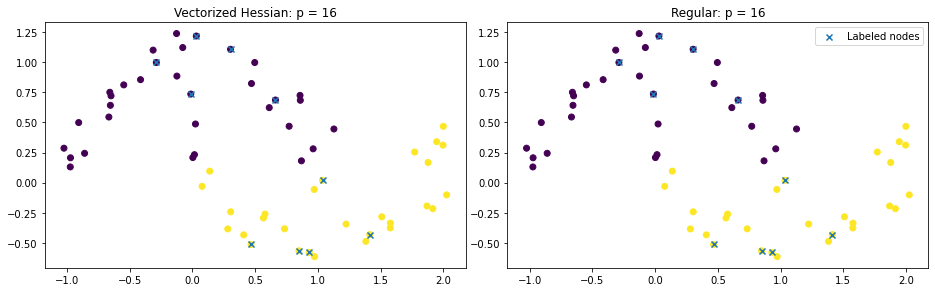

In [166]:
n = 60
k = 2
p = 16

fig, ax = plt.subplots(ncols = 2, figsize = (13, 4))
fig.tight_layout()

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)
    
# Hessian Gradient Descent
start_time = time.time()
hess_u = vectorized_hess_gradient_ppoisson(W, train_ind, y, p)
hess_pred_labels = predict(hess_u)

accuracy = gl.ssl.ssl_accuracy(hess_pred_labels, labels, len(train_ind))
energy = np.around(penergy(hess_u.flatten(), W, train_ind, y, p), 2)
end_time = time.time()
minutes = (end_time - start_time)/60

info_str = f"########### Vectorized Hessian Gradient Descent for p = {p}\n"\
                f"Energy = {energy:.2f}\n"\
                f"Accuracy = {accuracy:.2f}%\n"\
                f"Runtime = {minutes:.2f} min"

print(info_str)

ax[0].scatter(X[:,0],X[:,1], c=hess_pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
ax[0].set_title(f"Vectorized Hessian: p = {p}")



# Regular Gradient Descent
start_time = time.time()
my_u = started_gradient_ppoisson(W, train_ind, y, p)
my_pred_labels = predict(my_u)

discrepancies = np.count_nonzero(my_pred_labels - hess_pred_labels)
accuracy = gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind))
energy = np.around(penergy(my_u.flatten(), W, train_ind, y, p), 2)
end_time = time.time()
minutes = (end_time - start_time)/60

info_str = f"########### Regular Gradient Descent for p = {p}\n"\
                f"Energy = {energy:.2f}\n"\
                f"Discrepancies = {discrepancies}\n"\
                f"Accuracy = {accuracy:.2f}%\n"\
                f"Runtime = {minutes:.2f} min"

print(info_str)

ax[1].scatter(X[:,0],X[:,1], c=my_pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
ax[1].set_title(f"Regular: p = {p}")

plt.legend()
plt.show()


In [170]:
# Comparison of the two "hessians"
n = 20
p = 12

X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
u_flattened = u.flatten()

vectorized_hess = vectorized_hessian(u_flattened, W, idx, y, p)
hess = hessian(u_flattened, W, idx, y, p)
print(vectorized_hess)
print(hess)
print(vectorized_hess - hess)

[[ 1.10402099e+04 -2.44993327e+02 -3.39357339e-01 ... -2.88736593e-05
   0.00000000e+00  0.00000000e+00]
 [ 2.44993327e+02 -4.93044275e+03  5.73520491e-01 ... -2.06280505e-06
   0.00000000e+00  0.00000000e+00]
 [ 2.63040524e-01 -5.73520491e-01  4.96402158e+01 ... -2.89298320e+00
   2.29647028e-04 -7.01374296e-04]
 ...
 [ 2.88736593e-05  1.95241328e-06  2.89298320e+00 ... -1.92507375e+03
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.59671340e-04 ...  0.00000000e+00
   4.51200737e+01  1.78377562e-01]
 [ 0.00000000e+00  0.00000000e+00  7.01374296e-04 ...  0.00000000e+00
  -1.78377562e-01 -2.77728802e+01]]
[[58260.79926782 58260.79926782 58260.79926782 ... 58260.79926782
  58260.79926782 58260.79926782]
 [58260.79926782 58260.79926782 58260.79926782 ... 58260.79926782
  58260.79926782 58260.79926782]
 [58260.79926782 58260.79926782 58260.79926782 ... 58260.79926782
  58260.79926782 58260.79926782]
 ...
 [58260.79926782 58260.79926782 58260.79926782 ... 58260.79926